<a href="https://colab.research.google.com/github/gabassegio/Learning_ROS2/blob/developing/Using_a_fine_tunned_YOLOS_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# Here you should put the path of your image
IMAGE_PATH = "image.jpg"

In [14]:
# This is the order of the categories list. NO NOT CHANGE. Just for visualization purposes
cats = ['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']

In [15]:
def fix_channels(t):
    """
    Some images may have 4 channels (transparent images) or just 1 channel (black and white images), in order to let the images have only 3 channels. I am going to remove the fourth channel in transparent images and stack the single channel in back and white images.
    :param t: Tensor-like image
    :return: Tensor-like image with three channels
    """
    if len(t.shape) == 2:
        return ToPILImage()(torch.stack([t for i in (0, 0, 0)]))
    if t.shape[0] == 4:
        return ToPILImage()(t[:3])
    if t.shape[0] == 1:
        return ToPILImage()(torch.stack([t[0] for i in (0, 0, 0)]))
    return ToPILImage()(t)

In [16]:
def idx_to_text(i):
    return cats[i]

In [17]:
# Random colors used for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    detec = []
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        cl = p.argmax()
        if cl<29:

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          ax.text(xmin, ymin, idx_to_text(cl), fontsize=10,
                  bbox=dict(facecolor=c, alpha=0.8))
          detec.append([idx_to_text(cl),(xmin,ymin,xmax,ymax)])


    plt.axis('off')
    plt.show()
    plt.savefig("image.png")

In [18]:
def visualize_predictions(image, outputs, threshold=0.8):
    # keep only predictions with confidence >= threshold
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert predicted boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)


    # plot results
    plot_results(image, probas[keep], bboxes_scaled)


In [19]:
MODEL_NAME = "valentinafeve/yolos-fashionpedia"

In [20]:
feature_extractor = YolosFeatureExtractor.from_pretrained('hustvl/yolos-small')
model = YolosForObjectDetection.from_pretrained(MODEL_NAME)

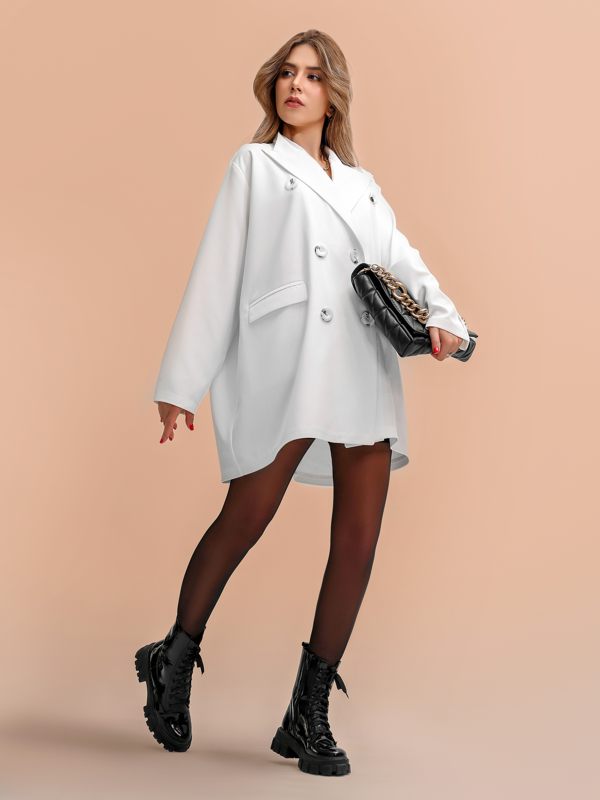

In [21]:
image = Image.open(open(IMAGE_PATH, "rb"))
image = fix_channels(ToTensor()(image))
image = image.resize((600, 800))
image

Photo by <a href="https://unsplash.com/@reza_delkhosh_?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Reza Delkhosh</a> on <a href="https://unsplash.com/photos/iRAOJYtPHZE?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>


In [22]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

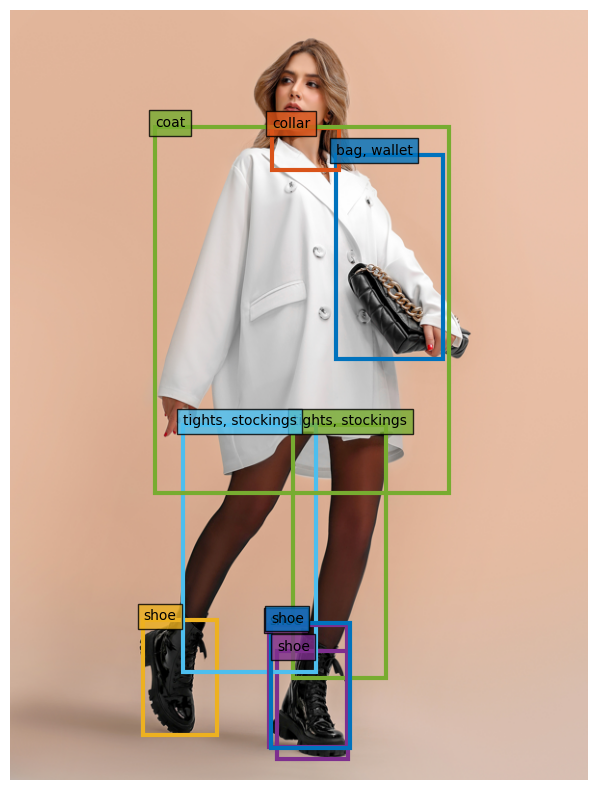

<Figure size 640x480 with 0 Axes>

In [23]:
img = visualize_predictions(image, outputs, threshold=0.5)

img